# House Price Predictions

## Goal
**Build a regression model to predict house price based on info in the data, then apply feature engineeering &feature selection to improve model's performance**

## Dataset
**This dataset contains house information for the city of Ames, Iowa from 2006 to 2010. Data was downloaded <a href="https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627">here</a>, and info regarding columns' definition can be found <a href="https://s3.amazonaws.com/dq-content/307/data_description.txt">here</a>**

## Import data and build a simple pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
house=pd.read_csv("AmesHousing.tsv",delimiter='\t')
house.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
len(house)

2930

First, Simply Write some functions to build a pipeline, and use one of them to build a simple linear regression for accuracy referrence


In [4]:
def transform_features(dataframe):
    return dataframe

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]


def train_and_test(df):
    #split data into train/test set
    train=df.iloc[:1460]
    test=df.iloc[1460:]
    
    #Filter out all numeric values
    numeric_train=train.select_dtypes(include=['integer','float'])
    numeric_test=test.select_dtypes(include=['integer', 'float'])
    
    #Train a model
    features_train=numeric_train.columns.drop("SalePrice")
    lr=LinearRegression()
    lr.fit(train[features_train], train['SalePrice'])
    predictions=lr.predict(test[features_train])
    
    #Evaluation
    mse=mean_squared_error(test['SalePrice'], predictions)
    rmse=np.sqrt(mse)
    
    return rmse

In [5]:
transform_house = transform_features(house)
filtered_house = select_features(transform_house)
rmse = train_and_test(filtered_house)

rmse

57088.25161263909

## Feature Engineering

**Data Cleaning**

- All Columns: Drop any columns with more than 5% null values

In [6]:
#Calculate missing values 
null_count=house.isnull().sum()

#Filter out results with more than 5% missing values
drop_cols=null_count[(null_count>len(house)/20)].sort_values()

#drop those columns
house=house.drop(drop_cols.index, axis=1)

In [7]:
#Check into columns dropped
drop_cols

Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Qual       159
Garage Cond       159
Lot Frontage      490
Fireplace Qu     1422
Fence            2358
Alley            2732
Misc Feature     2824
Pool QC          2917
dtype: int64

- Text Columns: Drop any with 1or more missing values

In [8]:
#Calculate missing values for text columns
null_text_count=house.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

#Filter out all columns with any missing values
drop_text=null_text_count[null_text_count>0]

#drop these columns
house=house.drop(drop_text.index, axis=1)

In [9]:
#Check into columns dropped
drop_text

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Mas Vnr Type      23
Electrical         1
dtype: int64

- Numeric Columns; Imputaion, replace null values with most common value in that column

In [10]:
#Filter out numeric columns
null_numeric_count=house.select_dtypes(include=['int','float']).isnull().sum()

#Filter out columns wich needs to be fixed
replace_numeric_cols = null_numeric_count[(null_numeric_count < len(house)/20) & (null_numeric_count > 0)].sort_values()

replace_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [12]:
#Check into the mode for each column
mode_dict=house[replace_numeric_cols.index].mode().to_dict(orient='records')[0]
mode_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [13]:
#Fill null values with mode
house=house.fillna(mode_dict)

In [14]:
#Check if dataframe contains 0 null values
house.isnull().sum().value_counts()

0    64
dtype: int64

- Check into times: Identify any possible anomolies

In [15]:
years_sold=house['Yr Sold']- house['Year Built']

years_sold[years_sold<0]

2180   -1
dtype: int64

In [16]:
years_remod=house['Yr Sold']-house['Year Remod/Add']
years_remod[years_remod<0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [17]:
#Add new columns respectively
house['Years Before Sale']=years_sold
house['Years Since Remod']=years_remod

#Drop rows with negative numbers
house.drop([1702, 2180, 2181], axis=0, inplace=True)

#Drop Original Columns
house.drop(['Year Built', 'Year Remod/Add'], axis=1, inplace=True)

Drop other columns which are useless, or contains leak information for ML

In [18]:
#Drop columns that aren't useful
house.drop(["PID", "Order"], axis=1,  inplace=True)

#Drop columns that strongly indicates the sale prices
house.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1, inplace=True)

In [19]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 58 columns):
MS SubClass          2927 non-null int64
MS Zoning            2927 non-null object
Lot Area             2927 non-null int64
Street               2927 non-null object
Lot Shape            2927 non-null object
Land Contour         2927 non-null object
Utilities            2927 non-null object
Lot Config           2927 non-null object
Land Slope           2927 non-null object
Neighborhood         2927 non-null object
Condition 1          2927 non-null object
Condition 2          2927 non-null object
Bldg Type            2927 non-null object
House Style          2927 non-null object
Overall Qual         2927 non-null int64
Overall Cond         2927 non-null int64
Roof Style           2927 non-null object
Roof Matl            2927 non-null object
Exterior 1st         2927 non-null object
Exterior 2nd         2927 non-null object
Mas Vnr Area         2927 non-null float64
Exter Qual    

**Update the process**

In [20]:
def transform_features(df):
    
    #Drop columns having more than 5% null values
    num_null=df.isnull().sum()
    num_null_drop=num_null[(num_null)>len(df)/20].sort_values()
    df=df.drop(num_null_drop.index, axis=1)
    
    #Drop any text columns which have null values
    text_null=df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    text_null_drop=text_null[text_null>0]
    df=df.drop(text_null_drop.index, axis=1)
    
    #Replace numeric null values with mode
    numeric_null=df.select_dtypes(include=['int','float']).isnull().sum()
    numeric_replace_col=numeric_null[(numeric_null< len(df)/20) & (numeric_null>0)].sort_values()
    mode_dict=df[numeric_replace_col.index].mode().to_dict(orient='records')[0]
    df=df.fillna(mode_dict)
    
    #Remove anamolies based on time
    years_sold=df['Yr Sold'] - df['Year Built']
    years_since_remod=df['Yr Sold']-df['Year Remod/Add']
    df['Years Before Sale']=years_sold
    df['Years Since Remod']=years_since_remod
    df=df.drop([1702, 2180, 2181], axis=0)
    
    df=df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df
    
    
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]



def train_and_test(df):
    #split data into train/test set
    train=df.iloc[:1460]
    test=df.iloc[1460:]
    
    #Filter out all numeric values
    numeric_train=train.select_dtypes(include=['integer','float'])
    numeric_test=test.select_dtypes(include=['integer', 'float'])
    
    #Train a model
    features_train=numeric_train.columns.drop("SalePrice")
    lr=LinearRegression()
    lr.fit(train[features_train], train['SalePrice'])
    predictions=lr.predict(test[features_train])
    
    #Evaluation
    mse=mean_squared_error(test['SalePrice'], predictions)
    rmse=np.sqrt(mse)
    
    return rmse

In [21]:
house=pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_house = transform_features(house)
filtered_house = select_features(transform_house)
rmse = train_and_test(filtered_house)

rmse

55275.36731241307

## Feature Selection

In [23]:
numeric_house=transform_house.select_dtypes(include=['int','float'])
numeric_house.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,62,0,0,0,0,0,2010,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,120,0,0,2010,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,36,0,0,0,0,12500,2010,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,2010,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,34,0,0,0,0,0,2010,189900,13,12


Check into the absolute value of correlation coefficient

In [24]:
abs_cor=numeric_house.corr()['SalePrice'].abs().sort_values()
abs_cor

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice 

Filter out those value of which is greater than 0.4

In [25]:
abs_cor[abs_cor > 0.4]

BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [26]:
#Drop columns correlation coefficient of which is less than 0.4
numeric_house = numeric_house.drop(abs_cor[abs_cor < 0.4].index, axis=1)

In [27]:
numeric_house.head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,SalePrice,Years Before Sale,Years Since Remod
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,2.0,528.0,215000,50,50
1,5,0.0,468.0,882.0,896,896,1,5,0,1.0,730.0,105000,49,49
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,1.0,312.0,172000,52,52
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,2.0,522.0,244000,42,42
4,5,0.0,791.0,928.0,928,1629,2,6,1,2.0,482.0,189900,13,12


In [28]:
numeric_house.shape

(2927, 14)

In [29]:
numeric_house.columns

Index(['Overall Qual', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
       '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Cars', 'Garage Area', 'SalePrice', 'Years Before Sale',
       'Years Since Remod'],
      dtype='object')

In [30]:
#Based on documentation, store categorical columns into a list
cat_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]


#Check if the numeric data has actual categorical values in the list
transform_cat_cols=[col for col in numeric_house.columns if col in cat_features]
transform_cat_cols

[]

**Update the Process**

In [34]:
def transform_features(df):
    
    #Drop columns having more than 5% null values
    num_null=df.isnull().sum()
    num_null_drop=num_null[(num_null)>len(df)/20].sort_values()
    df=df.drop(num_null_drop.index, axis=1)
    
    #Drop any text columns which have null values
    text_null=df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    text_null_drop=text_null[text_null>0]
    df=df.drop(text_null_drop.index, axis=1)
    
    #Replace numeric null values with mode
    numeric_null=df.select_dtypes(include=['int','float']).isnull().sum()
    numeric_replace_col=numeric_null[(numeric_null< len(df)/20) & (numeric_null>0)].sort_values()
    mode_dict=df[numeric_replace_col.index].mode().to_dict(orient='records')[0]
    df=df.fillna(mode_dict)
    
    #Remove anamolies based on time
    years_sold=df['Yr Sold'] - df['Year Built']
    years_since_remod=df['Yr Sold']-df['Year Remod/Add']
    df['Years Before Sale']=years_sold
    df['Years Since Remod']=years_since_remod
    df=df.drop([1702, 2180, 2181], axis=0)
    
    df=df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df




def select_features(df, coeff_threshold=0.4):
    numeric_df=df.select_dtypes(include=['int','float'])
    abs_cor=numeric_df.corr()['SalePrice'].abs().sort_values()
    df=df.drop(abs_cor[abs_cor<coeff_threshold].index, axis=1)
    return df



## Validation using K-Fold

**Update last function**

In [57]:
def train_and_test(df, k=0):
    
    numeric_df=df.select_dtypes(include=['integer','float'])
    train_features=numeric_df.columns.drop("SalePrice")
    lr=LinearRegression()
    
    #If k=0, perform a holdout validation
    if k==0:
        
        train=df[:1460]
        test=df[1460:]
        
        lr.fit(train[train_features], train['SalePrice'])
        predictions=lr.predict(test[train_features])
        mse=mean_squared_error(test['SalePrice'], predictions)
        rmse=np.sqrt(mse)
        
        return rmse
    
    elif k==1:
        
        shuffled_df=df.sample(frac=1)
        train=df[:1460]
        test=df[1460:]
        
        lr.fit(train[train_features], train['SalePrice'])
        predictions_one=lr.predict(test[train_features])
        
        mse_one=mean_squared_error(test['SalePrice'], predictions_one)
        rmse_one=np.sqrt(mse_one)
        
        lr.fit(test[train_features], test['SalePrice'])
        predictions_two=lr.predict(train[train_features])
        
        mse_two=mean_squared_error(train['SalePrice'], predictions_two)
        rmse_two=np.sqrt(mse_two)
        
    else:
        kfold=KFold(n_splits=k, shuffle=True)
        rmse_val=[]
        for train_index, test_index in kfold.split(df):
            train=df.iloc[train_index]
            test=df.iloc[test_index]
            lr.fit(train[train_features], train['SalePrice'])
            predictions=lr.predict(test[train_features])
            mse=mean_squared_error(test['SalePrice'], predictions)
            rmse=np.sqrt(mse)
            rmse_val.append(rmse)
            
        print(rmse_val)
        print("\n")
        print("Average RMSE: ",np.mean(rmse_val))
        
        plt.plot(range(k), rmse_val)
        plt.ylabel("RMSE")
        plt.xlabel("K (K Fold)")
        plt.xlim(2,k)
                

    

[33475.32176083661, 24708.66348638275, 32017.579773067435, 36522.48357992314, 31586.65063159771, 33411.31129353603, 26507.749083518484, 36778.38349040284, 28425.02178435528, 32804.348598151366, 24863.12984959887, 26546.432995041083, 37002.75909200262, 29455.379278427725, 29515.929459412062, 30756.0134657851, 27443.787647689984, 32180.44232632365, 62942.230765127846, 30360.69631955238]


Average RMSE:  32365.215734036647


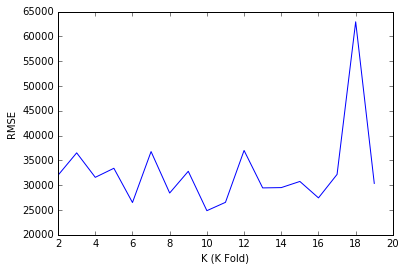

In [61]:
house = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_house = transform_features(house)
filtered_house = select_features(transform_house)
rmse = train_and_test(filtered_house, k=20)

rmse

## Conclusion
- After applying  data cleaning, feature engineering, and feature selection, RMSE decrease from 57088 to an average 32356